# Prieskumná (Exploratívna) analýza dát
Dáta predstavujú záznamy o pacientoch s chorobou štítnej žľazy. Cieľom je vedieť predikovať hodnotu Y. Cieľom tejto časti je zanalytovanie datasetu. Využívame exploratívnu analýzu, deskriptívnu štatistiku a rôzne podporné vizualizácie. Poukazujeme na viaceré problémy, ktoré sa v dátach
nachádzajú (formáty dát, chýbajúce, nezmyselné alebo vychýlené hodnoty a pod.). 

*POZNÁMKA - Základné informácie o problémoch so štítnou žlazou sme čerpali z* [https://bergendiova.blog.sme.sk/c/393035/8-veci-ktore-by-ste-mali-vediet-o-stitnej-zlaze-a-imunite.html]

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn
from sklearn import linear_model as lm

In [2]:
import dateutil.parser
import datetime

In [3]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (8, 6)
from IPython.display import Image, SVG, display

**AKCIA:** Vypíšeme si časť surových dát aby sme skontrolovali, či majú správny formát csv súboru.

In [4]:
%%bash 
head data/zadanie4/test.csv

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,class,fnlwgt,education,education-num,relationship,capital-gain,capital-loss,hours-per-week,date_of_birth,personal_info
0,68,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,3.0,t,2.6,t,117.0,t,1.24,t,94,f,?,SVI,negative.|1231,96245, HS-grad,9, Husband,0.0,0,99,1949-07-30,"Sales|United-States
Married-civ-spouse -- Self-emp-inc|White"
1,42,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.8,t,2.0,t,66.0,t,0.93,t,71,f,?,SVHC,negative.|329,191177, HS-grad,9, Not-in-family,,0,55,1975-10-31,"Exec-managerial|United-States
Never-married -- Private|White"
2,27,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,2.2,t,2.3,t,105.0,t,0.97,t,109,f,?,other,negative.|2518,48585, Some-college,1000, Wife,0.0,0,4,1990-10-29 00:00:00,"Prof-specialty|United

**POZOROVANIE:** Z prvých riadkov súboru sa zdá, že **atribúty** a ich hodnoty sú **odelené čiarkami** a **záznamy** sú **odelené znakom nového riadku**. Prvý riadok začína čiarkou, čo môže znamenať, že v súbore chýba názov prvého atribútu. Z hodnôt prislúchajúcich prvému atribútu odhadujeme, že sa jedná o **identifikačné číslo**.

**AKCIA:** Načítame si dataset s trénovacími dátami a vypíšeme si základnú informáciu o počte atribútov (stĺpcov) a počte záznamov (riadkov)

**KOREKCIA:** Prvý stlpec si zadefinujeme ako index

In [5]:
file_path = "data/zadanie4/train.csv"
#file_path = "data/zadanie4/test.csv"
# Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
data = pd.read_csv(file_path, sep=',', index_col=0)
# Pomenujeme si index
data.index.name = 'id'

In [17]:
# Vypíšeme si základné informácie o datasete
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 39 columns):
age                          2799 non-null float64
sex                          2800 non-null object
on thyroxine                 2800 non-null object
query on thyroxine           2800 non-null object
on antithyroid medication    2800 non-null object
sick                         2800 non-null object
pregnant                     2800 non-null object
thyroid surgery              2800 non-null object
I131 treatment               2800 non-null object
query hypothyroid            2800 non-null object
query hyperthyroid           2800 non-null object
lithium                      2800 non-null object
goitre                       2800 non-null object
tumor                        2800 non-null object
hypopituitary                2800 non-null object
psych                        2800 non-null object
TSH measured                 2800 non-null object
TSH                          2516 non-null

In [18]:
#Vypis spojitých atribútov typu floqat64
_ = data.select_dtypes('float64').describe()

In [19]:
#Vypis spojitých atribútov typu int64
_ = data.select_dtypes('int64').describe()

In [20]:
#Výpis atribútov s nešpecifikovaným dátovým typom
_ = data.select_dtypes('object').describe()

**POZOROVANIE:** Z týchto základných informácií môžeme pozorovať, že niektoré atribúty obsahujú aj **null hodnoty**. Pre atribúty spojité(kvantitatívne) atribúty **age, TSH, T3, TT4, T4U, capital-gain, date_of_birth** budeme musiet null hodnoty vhodne doplniť alebo vyradiť celý záznam z datasetu.
Na prvý pohľad nazvy niektorých atribútov *(napr. T3, TT4, T4U atď.)* nevieme čo znamenajú a preto bude potreba si naštudovať doménovú oblasť a pokusiť sa ich **lepšie zadefinovať**. Názvy atribútov tiež niesu konzistentné a to tak, že sa atribút skladá z viacerých slov *(napr. pomlčka, medzera, počiarkovník)*.  
**Počet riadkov:** 2800   
**Počet stĺpcov:** 39  
**Dátové typy:** float64(6), int64(4), object(29)  

*POZNÁMKA: Doménový opis dát a ich definície sú v súbore data_description.txt*

#  Analýza atribútov po jednom (Univariate analysis)
Na základe analýzy jednotlivých údajov sme atribúty rozdelili do niekoľkých skupín.

1. Osobné údaje
2. Liečba
3. Ochorenia
4. Vyšetrenia a výsledky
5. Otázky pacienta

## Osobné údaje
V tejto časti sú opísané atribúty opisujúce základné osobné údaje o pacientovi ako prácu, vek, pohlavie, rasu, štát, dátum narodenia atď.

### Atribút - personal_info

In [21]:
data['personal_info'].head()

id
0    Other-service|United-States\nWidowed -- privat...
1    Adm-clerical|United-States\nSeparated -- Local...
2    Sales|United-States\nMarried-civ-spouse -- pri...
3    Sales|United-States\nNever-married -- Private|...
4    Adm-clerical|United-States\nNever-married -- P...
Name: personal_info, dtype: object

**POZOROVANIE:** Usudzujeme, že tento atribút v sebe niesie niektoré **osobné údaje o pacientovi**. Na prvý pohľad môžeme vidieť, že atribút pozostáva z viacerých informácií. Do budúcna navrhujeme tento atribút rozdeliť na dalšie atribúty.

**KOREKCIA:** Atribút rozdelíme na 5 atribútov. [job, state, parents_definition, segment, race]

In [22]:
_ = pd.DataFrame(data['personal_info'].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=['job','state', 'parents_definition', 'segment', 'race'])

### Atribút - relationship

In [12]:
data['relationship'].head()

id
0     Unmarried
1     Unmarried
2       Husband
3     Own-child
4     Own_child
Name: relationship, dtype: object

**POZOROVANIE:** Usudzujeme, že tento atribút v sebe niesie niektoré **osobné údaje o pacientovi**. Na prvý pohľad môžeme vidieť, že atribút pozostáva z viacerých informácií. Do budúcna navrhujeme tento atribút rozdeliť na dalšie atribúty.

In [13]:
data['relationship'].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: relationship, dtype: int64

**POZOROVANIE:** Pri počítaní jednotlivých hodnôt v stĺpci "relationship" sme narazili na problém s nekonzistentnými dátami. Musíme ich upraviť na takú podobu, aby jednotlivé slová neboli oddelené pomlčkoiu, ale podtržníkom, t.j. máme dve hodnoty - other-relative a other_relative, ktoré očividne vyjadrujú to isté, ale sú ináč zapísané.

**KOREKCIA:** Zjednotíme názvy

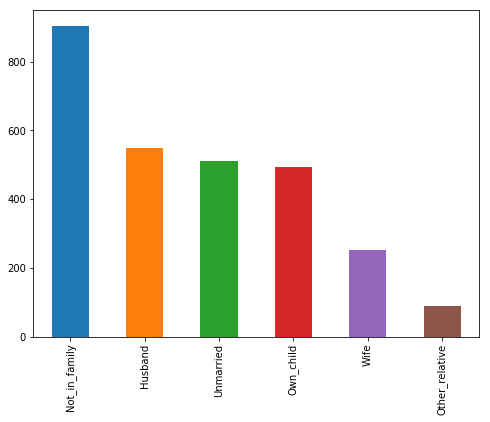

In [25]:
new_column = '_relationship'
data[new_column] = data['relationship'].apply(str.strip)
data[new_column] = data[new_column].replace('Other-relative', 'Other_relative')
data[new_column] = data[new_column].replace('Own-child', 'Own_child')
data[new_column] = data[new_column].replace('Not-in-family', 'Not_in_family')
data[new_column].value_counts().plot(kind='bar')


### Atribút - age

In [26]:
# Výpis prvých 5 záznamov pre daný atribút
data['age'].head()

id
0    72.0
1    52.0
2    62.0
3    23.0
4    63.0
Name: age, dtype: float64

**POZOROVANIE:** Kedže "age" v preklade znamená **vek** a tento atribút v sebe nesie číselné hodnoty usudzujeme, že nám **hovorí o veku pacientov**. Vek budeme považovat za **spojitý (kvantitatívny) intervalový atribút** (To znamená, že nad ním môžeme vykonať výpočtovú deskriptívnu štatistiku.)

In [27]:
# vykonáme deskriptívnu štatistiku
_ = data['age'].describe()

In [ ]:
column = 'age'
# Môžeme odstrániť chýbajúce hodnoty
#sample = data.loc[data[column].notna(), column]

# Alebo ich môžeme nahradiť za priemerný vek
sample = data[column].fillna(data[column].mean())

seaborn.set()
# Vykreslíme si histogram
_ = plt.hist(sample, bins=100)
_ = plt.xlabel('počet rokov')
_ = plt.ylabel('počet pacientov')
plt.show()

In [ ]:
_ = plt.boxplot(sample)

**POZOROVANIE:** Jeden pacient **nemá zaznamenaný údaj o veku** a aspoň jeden pacient má vyplnený nezmyselný **vek 455 rokov**. Takéto nezmyselné hodnoty môžeme odstrániť alebo doplniť na základe priemerného veku pacientov **52 rokov**.

**KOREKCIA:** Vyfiltrujeme si hodnoty, ktoré potrebujeme zmeniť a vypočítame hodnotu **veku**. V prípade ak by boli dáta zaznemané v rovnakom roku boli by sme schopní vypočítať tento rok ako "rok narodenia" + "prislúchajúci vek" a **chýbajúce hodnoty** pre **vek** podľa atribútu "vypočítaný rok" - "rok narodenia". Z takto upraveného datasetu by sme museli dodatočne vyfiltrovať nezmyselné hodnoty a nahradiť ich za **priemerný vek** pacientov. V prípade ak dáta nie sú z jedného roku, doplníme chýbajúci vek **priemerným vekom** všetkých pacientov v datasete.

In [ ]:
# Zistíme všetky hodnoty, ktoré sa nám zdajú nezmyslené alebo chýbajú
data[(data['age'] < 1) | (data['age'] > 100) | (pd.isnull(data['age']))]

In [ ]:
# Zistíme si mode (modus): najčastejšia hodnota (hodnota s najvačšou pravdepodobnostou vyskytu)
data['age'].mode()

**POZOROVANIE:** Môžeme si všimnúť, že väčšina pacientov v datasete je vo veku **59 rokov**.

### Atribút - date_of_birth

In [46]:
# Výpis prvých 5 záznamov pre daný atribút
data['date_of_birth'].head(20)

id
0     1946-02-03
1     1965-08-27
2     1955-04-15
3     1994-03-26
4     1955-01-21
5     1961-12-10
6     1934-03-03
7     1949-07-21
8     1999-01-06
9     1945-11-10
10    1999-09-20
11           NaN
12           NaN
13    1970-09-28
14    1942-08-15
15    07/07/1973
16    1979-12-04
17    18/01/1940
18    15/10/1952
19    1981-07-19
Name: date_of_birth, dtype: object

**POZOROVANIE:** Kedže **date_of_birth** v preklade znamená **dátum narodenia** a tento atribút v sebe nesie rôzne dátumy usudzujeme, že nám **hovorí o dátume narodenia pacientov**. Dátum narodenia budeme považovat za **spojitý (kvantitatívny) intervalový atribút**. Hodnoty atribútu majú **rôzny formát** a obsahujú aj **nan** hodnoty.

**KOREKCIA:** Ujednotenie formátu dátumov.

In [47]:
# Ujednotíme formát dátumov a všetky hodnoty z ktorých nebude možné vytvoriť date object preved na NaT hodnotu
column = '_date_of_birth'
data[column] = pd.to_datetime(data['date_of_birth'], errors='coerce')
# Vypíšeme si štatistiku
data[column].describe()
# Vyfiltrujeme si nezmyslený dátum
# data[data['clean_date'] == '2067-09-01 00:00:00']

count                    2362
unique                   2256
top       1983-08-20 00:00:00
freq                        3
first     1923-05-30 00:00:00
last      2067-09-01 00:00:00
Name: _date_of_birth, dtype: object

**POZOROVANIE:** Po zjednoteni datumov možeme vidieť, že v dátach sú pacienti, ktorí sa ešte nenarodili **2067-09-01**. Táto hodnota je zlá lebo pôvodná hodnota v subore.csv bola **67-09-01**, čo pravdepodobne predstavovalo dátum **1967-09-01**. Kedže funkcia pandas.to_datetime má svoje limitácie [http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#timestamp-limitations]navrhujeme] v ďaľšej časti navrhujeme odstrániť tieto dátumy.

### Atribút - sex

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['sex'].head()

**POZOROVANIE:** Kedže "sex" v preklade znamená **pohlavie** a na prvý pohľad vidíme hodnoty F *(female - žena)*, M *(male - muž)* usudzujeme, že nám hovorí o **pohlaví pacientov**. Pohlavie budeme považovat za **kategorický nominálny atribút**. 

In [ ]:
# zistíme si základné charakteristiky záznamov
data['sex'].describe()

**POZOROVANIE:** V datasete sa nachádzajú **3 typy pohlaví**. Pacienti sú väčšinou **ženy**.

In [ ]:
# Vypíšeme si unikátne hodnoty daného atribútu
data['sex'].value_counts()

*POZNÁMKA: Nemci uzákonili aj tretie pohlavie "intersex" [http://www.independent.co.uk/news/world/europe/germany-third-gender-male-female-intersex-court-parliament-bundesverfassungsgericht-berlin-lgbt-a8043261.html]*

**POZOROVANIE:** Dataset obsahuje tri pohlavia *F (female - žena), M (male - muž), **?** (chyba alebo intersex)*. Ak chýbajúcu hodnotu nebudeme považovať za tretie pohlavie budeme ju musieť vyzistiť z dalších atribútov.

In [ ]:
#Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím.
data[(data['sex'] == '?')].head()

**POZOROVANIE:** Chýbajúcu hodnotu môžeme zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**  

**KOREKCIA:** Vyfiltrujeme si pacientov, ktorých pohlavie je neznáme a sú tehotný. Ak je **pacient tehotný, potom je to žena**.

In [ ]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorá sú tehotní.
data[(data['sex'] == '?') & (data['pregnant'] == 't')].head()

In [ ]:
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data[(data['sex'] == 'M') & (data['relationship'] == ' Wife')]
#data[(data['sex'] == 'F') & (data['relationship'] == ' Husband')]

**POZOROVANIE:** Kedže neexistuje v datasete vydatý muž a oženená žena usudzujeme že podľa atribútu **relationship** môžeme určiť pohlavie.

**KOREKCIA:**  Ak je pacient vo **vzťahu vydatá** *(Wife)*, potom je **ženského pohlavia**. Ak je pacient vo vzťahu **oženený** *(Husband)*, potom je **mužského pohlavia**. 


### Atribút - hours-per-week

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['hours-per-week'].head()

In [ ]:
column = 'hours-per-week'
sample = data[column]
_ = plt.hist(sample, normed=True, bins=50)

**POZOROVANIE:** Niesme si istí, čo znamená tento atribút."hours-per-week" sa používa v spojení **vykonávať činnosť určitý počet hodín v týždni**. Vyzerá to, že hodnoty sú reprezentované v hodinách. Budeme ho považovať za **spojitý (kvantitatívny) intervalový atribút** a preto na ňom vykonáme štatistiku.

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['hours-per-week'].describe()

**POZOROVANIE:** Keď sa pozrieme na priemernú hodnotu **38.54** predpokladáme, že sa jedná o **pracovný čas** každého pacienta. Náš predpoklad je založený na tom, že bežná pracovná doba je 8 hodín denne 5 dní v týždni, čo sa rovná **40 hodinám**. Tieto dáta neobsahujú **žiadne null hodnoty** ani abnormálne výchylky a preto ich čistenie nie je potrebé.

## Liečba

### Atribút - on thyroxine

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['on thyroxine'].head()

**POZOROVANIE:** Tyroxin je hormón, ktorý je produkovaný štítnou žľazou.[https://www.newsmax.com/fastfeatures/thyroid-thyroxine/2016/03/24/id/720782/]. V prípade zníženej produkcie tohto hormónu sa predpisuje vo forme lieku. Usudzujeme, že tento atribút nám hovorí o tom, čí daný pacient užíva liek obsahujúci hormón tyroxín. Existujú len dva stavy. Buď pacient užíva liek alebo neužíva. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = užíva liek, false = neuziva liek].

In [ ]:
# data['on thyroxine'].unique()
data['on thyroxine'].value_counts()

**POZOROVANIE:** Vidíme, že náš predpoklad bol správny a hodnoty pre atribút majú iba dva stavy (true, false). Tieto dáta bude potreba **očistiť na jednotný formát**

**KOREKCIA:** Ujednotíme formát dát

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_on_thyroxine'
data[column] = data['on thyroxine'].map({'t': True, 'T': True, 'TRUE': True, 'f': False, 'F': False, 'FALSE': False})
data[column].value_counts()

### Atribút - query on thyroxine

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['query on thyroxine'].value_counts()

**POZOROVANIE:** Niesme si istý co predstavuje tento atribút.  Myslíme si, že tento atribút nám hovorí o tom, čí sa daný pacient sťažoval liek obsahujúci hormón tyroxín alebo sa naňho len pýtal. Existujú len dva stavy. Buď sa pacient sťažoval liek alebo nesťažoval. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = sťažoval sa/vypytoval, false = nesťažoval/nevypytoval].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_query_on_thyroxine'] = data['query on thyroxine'].map({'t': True, 'f': False})
data['_query_on_thyroxine'].value_counts()

### Atribút - on antithyroid medication

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['on antithyroid medication'].value_counts()

**POZOROVANIE:** Antithyroid je droga, ktorá znižuje funkciu štítnej žlazy. Používa sa v prípade ochorenia hypertireózy.[https://www.medicinenet.com/script/main/art.asp?articlekey=15316] Usudzujeme, že tento atribút nám hovorí o tom, čí daný pacient užíva drogu. Existujú len dva stavy. Buď pacient užíva drogu alebo neužíva. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = užíva drogu, false = neuziva drogu].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_on_antithyroid'] = data['on antithyroid medication'].map({'t': True, 'f': False})
data['_on_antithyroid'].value_counts()

### Atribút - I131 treatment

In [ ]:
# Výpis unikátnych hodnôt
data['I131 treatment'].value_counts()

**POZOROVANIE:** Radioaktívna, ktorá znižuje funkciu štítnej žlazy. [https://www.radiologyinfo.org/en/info.cfm?pg=radioiodine] Používa sa v prípade **ochorenia hypertireózy**. Usudzujeme, že tento atribút nám hovorí o tom, čí daný pacient podstupuje liečbu. Existujú len dva stavy. Buď pacient podstupuje liečbu alebo nepodstupuje. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = podstupuje liečbu, false = nepodstupuje liečbu].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_I131_treatment'] = data['I131 treatment'].map({'t': True, 'f': False})
data['_I131_treatment'].value_counts()

### Atribút - lithium

In [ ]:
# Výpis unikátnych hodnôt
data['lithium'].value_counts()

**POZOROVANIE:** Lítium je veľmi ľahký a mäkký kov, ktorý sa mnohými chemickými vlastnosťami podobá na horčík. Antityroidné účinky lítia sa najprv skúmali podrobne, keď sa zistilo, že pacienti s **psychiatrickým ochorením** liečeným lítium-karbonátom vyvinuli **hypotyreózu** a burcu. Štúdie na zvieratách a na ľuďoch následne odhalili, že lítium zvyšuje obsah intra-thyroidného jódu, inhibuje kondenzáciu jódotyrozínových zvyškov za vzniku jódtironínov (tyroxín (T4) a trijódtyronínu (T3)) a inhibuje uvoľňovanie T4 a T3.[https://www.uptodate.com/contents/lithium-and-the-thyroid#H2] Používa sa v prípade **ochorenia hypertireózy**. Usudzujeme, že tento atribút nám hovorí o tom, čí daný pacient podstupuje liečbu. Existujú len dva stavy. Buď pacient podstupuje liečbu alebo nepodstupuje. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = podstupuje liečbu, false = nepodstupuje liečbu].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_lithium'] = data['lithium'].map({'t': True, 'f': False})
data['_lithium'].value_counts()

### Atribút - thyroid surgery

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['thyroid surgery'].value_counts()

**POZOROVANIE:** [https://youtu.be/0h5jM7eN6j4] Usudzujeme, že tento atribút nám hovorí o tom, čí sa daný pacient podstúpil operáciu. Existujú len dva stavy. Buď pacient podstúpil operáciu ale nepodstúpil. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = podstúpil operáciu, false = nepodstúpil operáciu].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_thyroid_surgery'] = data['thyroid surgery'].map({'t': True, 'f': False})
data['_thyroid_surgery'].value_counts()

## Ochorenia

### Atribút - sick

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['sick'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, čí sa daný pacient je chorý. Existujú len dva stavy. Buď je pacient chorý alebo nie je chorý. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = je chorý, false = nie je chorý].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_sick'] = data['sick'].map({'t': True, 'f': False})
data['_sick'].value_counts()

### Atribút - goitre

In [ ]:
# Výpis unikátnych hodnôt
data['goitre'].value_counts()

**POZOROVANIE:** [https://youtu.be/TiBnSKyX2iU] Usudzujeme, že tento atribút nám hovorí o tom, čí sa daný trpí ochorením. Existujú len dva stavy. Buď pacient trpí ochorením alebo nie. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = má ochorenie, false = nemá ochorenie].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_goitre'] = data['goitre'].map({'t': True, 'f': False})
data['_goitre'].value_counts()

### Atribút - tumor

In [ ]:
# Výpis unikátnych hodnôt
data['tumor'].value_counts()

**POZOROVANIE:** [https://www.endocrineweb.com/conditions/thyroid-cancer/thyroid-cancer] Usudzujeme, že tento atribút nám hovorí o tom, čí sa daný trpí ochorením. Existujú len dva stavy. Buď pacient trpí ochorením alebo nie. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = má ochorenie, false = nemá ochorenie].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_tumor'] = data['tumor'].map({'t': True, 'f': False})
data['_tumor'].value_counts()

### Atribút - hypopituitary

In [ ]:
# Výpis unikátnych hodnôt a ich počtov
data['hypopituitary'].value_counts()

**POZOROVANIE:** [https://www.emedicinehealth.com/hypopituitary/article_em.htm] Usudzujeme, že tento atribút nám hovorí o tom, čí sa daný trpí ochorením. Existujú len dva stavy. Buď pacient trpí ochorením alebo nie. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = má ochorenie, false = nemá ochorenie]. V našom data sete sa nachádza iba jeden jediný pacient s takýmto ochorením. Tento pacient pravdepodobne len veľmi málo ovplyvní výledky budúceho trénovania a preto si myslíme, že by bolo vhodné tento atribút **zanedbať**.

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_hypopituitary'] = data['hypopituitary'].map({'t': True, 'f': False})
data['_hypopituitary'].value_counts()

### Atribút - psych

In [ ]:
# Výpis unikátnych hodnôt a ich počtov
data['psych'].value_counts()

**POZOROVANIE:** [https://www.ncbi.nlm.nih.gov/pubmed/21996646] Usudzujeme, že tento atribút nám hovorí o tom, čí daný pacient trpí ochorením. Existujú len dva stavy. Buď pacient trpí ochorením alebo nie. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = má ochorenie, false = nemá ochorenie].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_psych'] = data['psych'].map({'t': True, 'f': False})
data['_psych'].value_counts()

### Atribút - pregnant

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['pregnant'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient **tehotný**. Existujú len dva stavy. Buď je pacient tehotný alebo nie je tehotný. Preto budeme tento atribút považovat za **kategorický binárny atribút**, ktorý v sebe bude niesť hodnoty [true = je tehotný, false = nie je tehotný].

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
data['_pregnant'] = data['pregnant'].map({'t': True, 'f': False})
data['_pregnant'].value_counts()

## Vyšetrenia a ich výsledky

### Atribút - TSH

*POZNÁMKA - A TSH test is done to find out if your thyroid gland is working the way it should. It can tell you if it’s overactive (hyperthyroidism) or underactive (hypothyroidism). The test can also detect a thyroid disorder before you have any symptoms. If untreated, a thyroid disorder can cause health problems.  
TSH stands for “thyroid stimulating hormone” and the test measures how much of this hormone is in your blood. TSH is produced by the pituitary gland in your brain. This gland tells your thyroid to make and release the thyroid hormones into your blood* [https://www.webmd.com/a-to-z-guides/what-is-tsh-test#1]

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['TSH'].head()

**POZOROVANIE:** Na základe vyšieho opisu a toho, že atribút v sebe nesie číselné hodnoty usudzujeme, že nám **vyšetrení hladiny hormónu v krvi**. Tieto hodnoty budeme považovať za **spojitý (kvantitatívny) pomerový atribút**.

In [ ]:
# vykonáme deskriptívnu štatistiku
data['TSH'].describe(include='all')

In [ ]:
# Pozrieme sa na najbežnejšie hodnoty
atribute = 'TSH'
sample = data.loc[data[atribute].notna(), atribute]
_ = plt.hist(sample, bins=100)

**POZOROVANIE:** Môžeme vidieť, že hodnoty sa pohybujú okolo **0.**. Usúdzujeme, že výsledky vyšetrenia sú malé desatinné čísla a všetkým väčším číslam by sme mali klásť väčší dôraz.

### Atribút - TSH measured

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['TSH measured'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient podstúpil vyšetrenie. Existujú len dva stavy. Buď podstúpil (t) alebo nepodstúpil(f). Preto budeme tento atribút považovat za **kategorický binárny atribút**

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_TSH_measured'
data[column] = data['TSH measured'].map({'t': True, 'f': False})
data[column].value_counts()

### Atribút - T3

*POZNÁMKA - Prvým izolovaným hormónom produkovaným štítnou žľazou bol hormón T4. Spočiatku bol považovaný za hlavný hormón štítnej žľazy, neskôr sa však ukázalo, že ide skôr o prohormón, pretože doposiaľ nebola zistená žiadna jeho priama akcia v tele. Jeho aktivita je nepriama, nakoľko slúži ako zdroj pre vytváranie aktívneho hormónu T3.
Časť T3 (asi 20%) pochádza priamo zo štítnej žľazy, zvyšok vzniká konverziou T4 na T3 v pečeni, obličkách, svaloch a centrálnom nervovom systéme. Nie všetka T4-ka sa transformuje na T3-ku. T4 predstavuje zásobáreň neaktívneho hormónu štítnej žľazy v krvi.
Hladina hormónov T4 a T3 je riadená spätnoväzobným mechanizmom prostredníctvom hormónu TSH. Ak je hladina T4 a T3 zvýšená, klesne hladina TSH, čím sa obmedzí tvorba hormónov a naopak, ak je hladina nízka, zvýši sa TSH, čo vedie k zvýšeniu produkcie štítnej žľazy. TSH pôsobí aj na veľkosť štítnej žľazy. Nízka hladina TSH znamená jej zmenšovanie.*
Viac tu: [https://vsetkooanabolikach.webnode.sk/news/t3-je-jednou-z-najucinnejsich-latok-v-boji-proti-tuku-/]

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['T3'].head()

**POZOROVANIE:** Na základe vyšieho opisu a toho, že atribút v sebe nesie číselné hodnoty usudzujeme, že nám **vyšetrení hladiny hormónu v krvi**. Tieto hodnoty budeme považovať za **spojitý (kvantitatívny) pomerový atribút**. Vidíme, že niektoré hodnoty sú NaN, takže stĺpec bude potrebné očistiť o tieto hodnoty alebo si ich upraviť.)

In [ ]:
# vykonáme deskriptívnu štatistiku
data['T3'].describe()

In [ ]:
# Pozrieme sa na najbežnejšie hodnoty
atribute = 'T3'
sample = data.loc[data[atribute].notna(), atribute]
#sample = data[atribute].interpolate()
_ = plt.hist(sample, bins=100)
_ = plt.xlabel('hladina hormónu ' + atribute)
_ = plt.ylabel('počet pacientov')

In [ ]:
data['T3'].mode()

**POZOROVANIE:** Môžeme vidieť, že hodnoty sa pohybujú okolo **2.**. Usúdzujeme, že výsledky vyšetrenia sú malé desatinné čísla a všetkým väčším číslam by sme mali klásť väčší dôraz.

### Atribút - T3 measured

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['T3 measured'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient podstúpil vyšetrenie. Existujú len dva stavy. Buď podstúpil (t) alebo nepodstúpil(f). Preto budeme tento atribút považovat za **kategorický binárny atribút**

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_T3_measured'
data[column] = data['T3 measured'].replace({'t': True, 'f': False})
data[column].value_counts()

### Atribút - TT4

*POZNÁMKA - Prvým izolovaným hormónom produkovaným štítnou žľazou bol hormón T4. Spočiatku bol považovaný za hlavný hormón štítnej žľazy, neskôr sa však ukázalo, že ide skôr o prohormón, pretože doposiaľ nebola zistená žiadna jeho priama akcia v tele. Jeho aktivita je nepriama, nakoľko slúži ako zdroj pre vytváranie aktívneho hormónu T3.
Časť T3 (asi 20%) pochádza priamo zo štítnej žľazy, zvyšok vzniká konverziou T4 na T3 v pečeni, obličkách, svaloch a centrálnom nervovom systéme. Nie všetka T4-ka sa transformuje na T3-ku. T4 predstavuje zásobáreň neaktívneho hormónu štítnej žľazy v krvi.
Hladina hormónov T4 a T3 je riadená spätnoväzobným mechanizmom prostredníctvom hormónu TSH. Ak je hladina T4 a T3 zvýšená, klesne hladina TSH, čím sa obmedzí tvorba hormónov a naopak, ak je hladina nízka, zvýši sa TSH, čo vedie k zvýšeniu produkcie štítnej žľazy. TSH pôsobí aj na veľkosť štítnej žľazy. Nízka hladina TSH znamená jej zmenšovanie.*
Viac tu: [https://vsetkooanabolikach.webnode.sk/news/t3-je-jednou-z-najucinnejsich-latok-v-boji-proti-tuku-/]

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['TT4'].head()

**POZOROVANIE:** Na základe vyšieho opisu a toho, že atribút v sebe nesie číselné hodnoty usudzujeme, že nám **vyšetrení hladiny hormónu v krvi**. Tieto hodnoty budeme považovať za **spojitý (kvantitatívny) pomerový atribút**.

In [ ]:
# vykonáme deskriptívnu štatistiku
data['TT4'].describe()

In [ ]:
# Pozrieme sa na najbežnejšie hodnoty
atribute = 'TT4'
sample = data.loc[data[atribute].notna(), atribute]
#sample = data[atribute].interpolate()
_ = plt.hist(sample, bins=100)
_ = plt.xlabel('hladina hormónu ' + atribute)
_ = plt.ylabel('počet pacientov')

In [ ]:
data['TT4'].mode()

**POZOROVANIE:** Môžeme vidieť, že hodnoty sa pohybujú okolo **101.**. Usúdzujeme, že výsledky vyšetrenia sú malé desatinné čísla a všetkým väčším číslam by sme mali klásť väčší dôraz.

### Atribút - TT4 measured

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['TT4 measured'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient podstúpil vyšetrenie. Existujú len dva stavy. Buď podstúpil (t) alebo nepodstúpil(f). Preto budeme tento atribút považovat za **kategorický binárny atribút**

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_TT4_measured'
data[column] = data['TT4 measured'].replace({'t': True, 'f': False})
data[column].value_counts()

### Atribút - T4U

*POZNÁMKA - *

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['T4U'].head()

**POZOROVANIE:** Na základe vyšieho opisu a toho, že atribút v sebe nesie číselné hodnoty usudzujeme, že nám **vyšetrení hladiny hormónu v krvi**. Tieto hodnoty budeme považovať za **spojitý (kvantitatívny) pomerový atribút**.

In [ ]:
# vykonáme deskriptívnu štatistiku
data['T4U'].describe()

In [ ]:
# Pozrieme sa na najbežnejšie hodnoty
atribute = 'T4U'
sample = data.loc[data[atribute].notna(), atribute]
#sample = data[atribute].interpolate()
_ = plt.hist(sample, bins=100)
_ = plt.xlabel('hladina hormónu ' + atribute)
_ = plt.ylabel('počet pacientov')

In [ ]:
data['T4U'].mode()

**POZOROVANIE:** Môžeme vidieť, že hodnoty sa pohybujú okolo **0.99**. Usúdzujeme, že výsledky vyšetrenia sú malé desatinné čísla a všetkým väčším číslam by sme mali klásť väčší dôraz.

### Atribút - TT4 measured

In [ ]:
# Výpis prvých 5 záznamov pre daný atribút
data['TT4 measured'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient podstúpil vyšetrenie. Existujú len dva stavy. Buď podstúpil (t) alebo nepodstúpil(f). Preto budeme tento atribút považovat za **kategorický binárny atribút**

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_TT4_measured'
data[column] = data['TT4 measured'].replace({'t': True, 'f': False})
data[column].value_counts()

### Atribút - FTI

*POZNÁMKA - *Index volného tyroxinu. Voľný tyroxín (T4) môže byť meraný priamo (FT4) alebo kalkulovaný ako index voľného tyroxínu (FTI). FTI popisuje, ako veľa voľného T4 je prítomné v porovnaní s viazaným T4. FTI nám pomáha povedať, či abnormálne množstvá T4 sú prítomné kvôli abnormálnym množstvám TBG (thyroxine-binding globulin).

In [ ]:
data['FTI'].head()

**POZOROVANIE:** Na základe vyšieho opisu a toho, že atribút v sebe nesie číselné hodnoty usudzujeme, že nám **vyšetrení hladiny hormónu v krvi**. Tieto hodnoty budeme považovať za **spojitý (kvantitatívny) pomerový atribút**.

In [ ]:
# vykonáme deskriptívnu štatistiku
data['T4U'].describe()

In [ ]:
# Pozrieme sa na najbežnejšie hodnoty
atribute = 'FTI'
sample = data.loc[data[atribute].notna(), atribute]
#sample = data[atribute].interpolate()
_ = plt.hist(sample, bins=100)
_ = plt.xlabel('hladina hormónu ' + atribute)
_ = plt.ylabel('počet pacientov')

In [ ]:
data['FTI'].mode()

**POZOROVANIE:** 

### Atribút - FTI measured

In [ ]:
data['FTI measured'].head()

In [ ]:
data['FTI measured'].value_counts()

**POZOROVANIE:** Usudzujeme, že tento atribút nám hovorí o tom, či je daný pacient podstúpil vyšetrenie. Existujú len dva stavy. Buď podstúpil (t) alebo nepodstúpil(f). Preto budeme tento atribút považovat za **kategorický binárny atribút**

**KOREKCIA:** Prekonvertujeme si formát dát na boolean hodnoty

In [ ]:
# Mapovanie True a False na hodnoty podľa toho ake si zvolíme
column = '_FTI_measured'
data[column] = data['FTI measured'].replace({'t': True, 'f': False})
data[column].value_counts()

### Atribút - TBG

*POZNÁMKA - * Thyroid-binding globulin (TBG) je produkovaný v pečeni a viaže tyroidové hormóny v cirkulácii. Je to jeden z troch transportných proteínov, zodpovedných za nosenie tyroidových hormńov tyroxín (T4) a triodotrynov (T3) v krvnom obehu.

 

In [ ]:
data['TBG'].head()

In [ ]:
data['TBG'].unique()

**POZOROVANIE:** NA základe toho, že všetky hodnoty atribútu TBG sú neznáme tak tento atribút môžeme vynechať. Deskriptívne štatistiky nemajú zmysel.

**KOREKCIA:** tento atribút je vhodné zmazať, pretože nám neposkytuje žiadne údaje. 

### Atribút - TBG measured

In [ ]:
data['TBG measured'].head()

In [ ]:
data['TBG measured'].value_counts()

**POZOROVANIE:** Na základe toho, že atribút TBG očividne nebol zaznamenaný môžeme vidieť že nebol meraný ani pri jednom pacientovi.

**KOREKCIA:** Tento atribút môžeme odstrániť

### Atribút - referral source

In [ ]:
# výpis prvých 5 hodnôt atribútu
data['referral source'].head()

In [ ]:
# Výpis unikátnych hodnôt a ich počtov
data['referral source'].value_counts()

**POZOROVANIE:** referral source v preklade znamená referenčný zdroj. na prvý pohľad vidíme, že obsahuje 5 rôznych hondnôt - SVI, SVHC, STMW, SVHB. Sú to metódy testovania. Referenčný zdroj budeme považovat za kategorický nominálny atribút.

**KOREKCIA:** v tomto atribúte sa nenachádzajú žiadne podozrivé hodnoty, ktoré by si vyžadovali úpravu.

### Atribút - class

In [ ]:
# výpis prvých 5 hodnôt atribútu
data['class'].head()

**POZOROVANIE:** Pri prvom pohľade vidíme jeden problém a to že tento stĺpec vieme rozdeliť do dvoch rôznych. Prvý podľa obsahu indikuje že sa jedná o stav liečby, ktorá je na pacientoví vykonávaná (replacement therapy je hormonálna terapia, ktorou sa pacientovi do tela dodáva chýbajúci hormón). 

**KOREKCIA:** rozdelenie tohto atribútu do dvoch separátnych a následné upravenie hodnôt vo vzniknutých atribútoch ak to bude treba.

In [ ]:
_ = pd.DataFrame(data["class"].str.split('\.\|').tolist(), columns = ['unknown_1','unknown_2'])

### Atribút - fnlwgt

In [ ]:
# výpis prvých 5 hodnôt atribútu
data['fnlwgt'].head()

**POZOROVANIE:** fnlwgt [https://www.kaggle.com/uciml/adult-census-income] - skratka od **final weight** - váha pozorovaného segmentu

### Atribút - education

In [ ]:
# výpis prvých 5 hodnôt atribútu
data['education'].head()

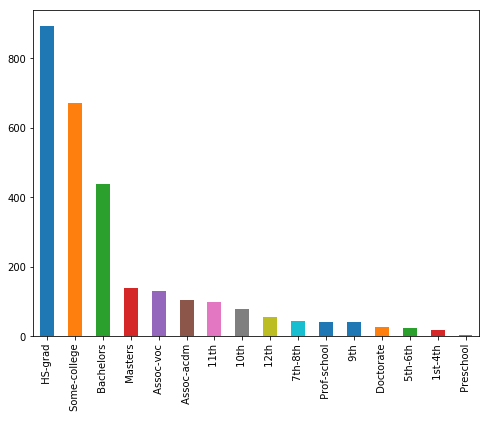

In [29]:
data['education'].value_counts().plot(kind="bar")

In [30]:
# zistíme si základné charakteristiky záznamov
data['education'].describe()

count         2800
unique          16
top        HS-grad
freq           894
Name: education, dtype: object

**POZOROVANIE:** education - v preklade znamená vzdelanie. Tento atribút nám hovorí tom, aké má pacient dosiahnuté maximálne vzdelanie. V datasete vidíme že má niekoľko unikátnych hodnôt, pričom najviac pacientov dosiahlo vzdelanie hodnoty "HS-grad" teda stredoškolské vzdelanie s maturitou. Podľa názvu tohto atribútu môžme povedať, že bude nejakým spôsobom súvisieť s atribútom "education-num". Vzdelanie budeme považovať za **kategorický ordinálny atribút**. 

In [ ]:
# pozrieme sa na stĺpce education a education-num
data[['education', 'education-num']].head(20)

**POZOROVANIE:** Na prvý pohľad vieme povedať, že jednotlivé stupne vzdelania by mali mať rovnaké education-num, no v našom prípade nemajú. Vidíme však istú podobnosť v jednotlivých hodnotách, napríklad že väčšinou stupeň "HS-grad" má education-num 9, no vyskytujú sa aj hodnoty, ako -900, alebo 900. Hodnoty sú vo veľkom nepomere ale zhodujú sa v číslici 9. Rovnakú podobnosť vidíme aj pri ostatných stupňoch vzdelania. 

### Atribút - education-num

In [ ]:
data['education-num'].head()

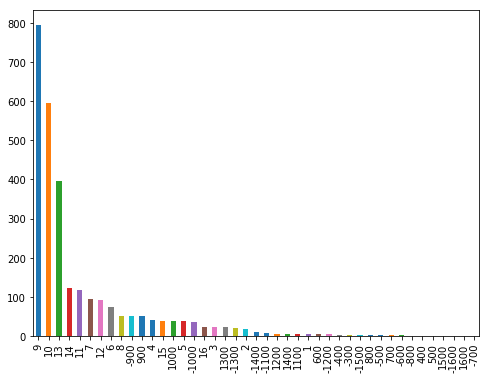

In [36]:
data['education-num'].value_counts().plot(kind='bar')

**POZOROVANIE:** Education-num - číselné označenie stupňa vzdelania. Pri tomto atribúte môžme povedať že vyjadruje rovnakú vec ako atribút "education", ale tento ho vyjadruje ako Number narozdiel od education, ktorý ju vyjadruje ako String. Vzdelanie budeme považovať za **kategorický ordinálny atribút**. [https://en.wikipedia.org/wiki/Educational_stage]

**KOREKCIA:** Jednotlivé hodnoty treba dať do jednotného formátu, teda hodnoty ako 900, alebo -900 musíme zmeniť na 9 a podobne pri všetkých ostatných hodnotách, ktoré prejavujú istú podobnosť. 

# Dobrá práca Vyskoč ! skoč na to.

### Spojité atribúty (Kvantitatívne)
#### Intervalové
age, date_of_birth, hours-per-week <br/> 
#### Pomerové
TSH, T3, TT4, T4U, FTI, fnlwgt, capital-gain, capitital-loss <br/>
### Kategorické atribúty
#### Nominálne atribúty (hint. kategórie, stavy, mená, lable, tagy)
referral source - <br/>
class - <br/>
personal_info - <br/>
##### Binárne atribúty (hint. kategórie, stavy, mená, lable, tagy)
*Symetrické*<br/>
sex [M,F] - M = muž, F = žena<br/>
on thyroxine [f, t] - f = false, t = true  <br/>
sick [f, t] - f = false, t = true<br/>
pregnant [f, t] - f = false, t = true<br/>
thyroid surgery [f, t] - f = false, t = true<br/>
I131 treatment [f, t] - f = false, t = true<br/>
on antithyroid medication [f, t] - f = false, t = true<br/>
query hypothyroid [f, t] - f = false, t = true<br/>
lithium [f, t] - f = false, t = true<br/>
goitre [f, t] - f = false, t = true<br/>
tumor [f, t] - f = false, t = true<br/>
hypopituitary [f, t] - f = false, t = true<br/>
psych [f, t] - f = false, t = true<br/>
TSH measured [t, f] - f = false, t = true<br/>
T3 measured [t, f] - f = false, t = true<br/>
TT4 measured [t, f] - f = false, t = true<br/>
T4U measured [f, t] - f = false, t = true<br/>
FTI measured [f, t] - f = false, t = true<br/>
TBG measured [f, t] - f = false, t = true<br/>
#### Ordinálne
education [] - <br/>
education_num - <br/>

# Analýza atribútov po pároch (Bivariate analysis)
V tejto časti sú vysvetlené a zobrazené vlastnosti atribútov, ktoré spolu môžu súvisieť.

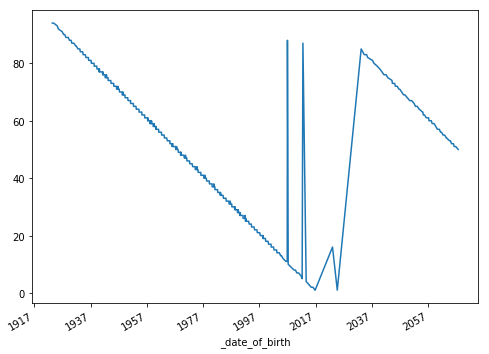

In [48]:
column = '_date_of_birth'
# nastavíme si index na dátum narodenia
sample = data.set_index([column])
# vykreslíme si vek s dátumami
sample.loc[(sample['age'].notna()),'age'].plot()

**POZOROVANIE:** Z vykresleného môžeme usúdiť, že dataset bol vytvorený **okolo roku 2017**. Všetky dátumy narodenia vyššie ako 2017 môžeme považovať za zlé a tiež môžeme vidieť, že nejaké datumy narodenia nesedia s vekom. Niektore zle hodnoty je možné prekonvertovať spôsobom: 2057 -> 1957

In [43]:
#pd.crosstab(index=data['TSH_measured'], columns=data['TSH']).plot(kind='box')

In [ ]:
sample = data.dropna()
seaborn.pairplot(sample.loc[:,['TSH', 'T4U', 'T3', 'TT4']])

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
seaborn.heatmap(sample.loc[:,['TSH', 'T4U', 'T3', 'TT4', ]].corr(), ax=ax, annot=True, fmt=".3f")

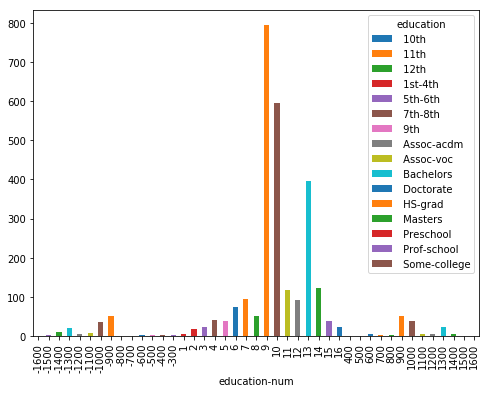

In [44]:
pd.crosstab(index=data['education-num'], columns=data['education']).plot.bar(stacked=True)